In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('kenya_tripadvisor_data_1.csv')
df1.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [3]:
df2 = df1.copy()
df2.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [4]:
from nltk import tokenize

df2.drop('Rating', axis = 1, inplace = True)
df2.drop('Date', axis = 1, inplace = True)
df2['Review Head'] = df2['Review Head'].apply(lambda x: re.sub('\s+', ' ', x))
df2['Review Body'] = df2['Review Body'].apply(lambda x: re.sub('\s+', ' ', x))
df2['RB_Sentence1'] = df2['Review Body'].apply(lambda x: tokenize.sent_tokenize(x)[0])
df2['RH_Split'] = df2['Review Head'].apply(lambda x: x.split(' '))
df2['RB_Split'] = df2['Review Body'].apply(lambda x: x.split(' '))
df2['RB_Sentence1_Split'] = df2['RB_Sentence1'].apply(lambda x: x.split(' '))
df2['TextBlob Polarity Head'] = df2['Review Head'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity Body'] = df2['Review Body'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity RBS1'] = df2['RB_Sentence1'].map(lambda text: TextBlob(text).sentiment.polarity)

In [5]:
df2.head()

,Destination Name,Destination Type,Review Head,Review Body,RB_Sentence1,RH_Split,RB_Split,RB_Sentence1_Split,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity RBS1
0,Giraffe Centre,Nature/Parks,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,If you find yourself with a day in Nairobi bef...,"[Giraffes, and, Baby, Elephants!]","[If, you, find, yourself, with, a, day, in, Na...","[If, you, find, yourself, with, a, day, in, Na...",0.0,0.160000,0.16
1,Giraffe Centre,Nature/Parks,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,A fun place to visit - you not only get to fee...,"[Places, to, visit, in, Karen, -, Giraffe, Cen...","[A, fun, place, to, visit, -, you, not, only, ...","[A, fun, place, to, visit, -, you, not, only, ...",0.0,0.450000,0.15
2,Giraffe Centre,Nature/Parks,Close to the giraffes,You get to come very close to the giraffes. Yo...,You get to come very close to the giraffes.,"[Close, to, the, giraffes]","[You, get, to, come, very, close, to, the, gir...","[You, get, to, come, very, close, to, the, gir...",0.0,0.100000,0.20
3,Giraffe Centre,Nature/Parks,Giraffe kiss!,If you like giraffes you'll love this place. E...,If you like giraffes you'll love this place.,"[Giraffe, kiss!]","[If, you, like, giraffes, you'll, love, this, ...","[If, you, like, giraffes, you'll, love, this, ...",0.0,0.200000,0.50
4,Giraffe Centre,Nature/Parks,A wonderful moment in time.,We always visit this attraction each and every...,We always visit this attraction each and every...,"[A, wonderful, moment, in, time.]","[We, always, visit, this, attraction, each, an...","[We, always, visit, this, attraction, each, an...",1.0,0.214286,0.00


In [6]:
df2['Destination Type'].value_counts()

Nature/Parks    21143
Museums          4685
Landmarks        3307
Name: Destination Type, dtype: int64

### Topic Modelling

In [7]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df2['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 16736
Neutral : 112476
Negative : 618


In [8]:
from nltk.corpus import stopwords

# main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
#                        'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
#                        'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
#                        'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
#                        '\n', '‘s']

main_stop_words = ['kenya', 'kenyan', 'africa', 'african', 'church', 'churches', 'park', 'parks', 'museum', 'museums',
                   'lamu', 'valley', 'mountain', 'mountains', 'national', 'nairobi', 'amboseli'  
                   'cathedral', 'cathedrals', 'place', 'visit', 'site', 'town',  
                   '\n', '‘s']

positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1493


In [9]:
# Convert to list
data = df2[df2['Destination Type'] == 'Nature/Parks'][df2['TextBlob Polarity Head'] < 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Go before it is too late']


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['go', 'before', 'it', 'is', 'too', 'late']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['go', 'before', 'it', 'is', 'too', 'late']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['go', 'late']]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('go', 1), ('late', 1)]]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.222*"worth" + 0.043*"drive" + 0.042*"activity" + 0.036*"plentiful" + '
  '0.036*"shaba" + 0.034*"trip" + 0.031*"really" + 0.026*"dry" + 0.016*"sight" '
  '+ 0.015*"tough"'),
 (1,
  '0.129*"small" + 0.098*"time" + 0.054*"gem" + 0.051*"much" + 0.041*"see" + '
  '0.036*"hide" + 0.031*"black" + 0.028*"young" + 0.025*"seriously" + '
  '0.025*"pink"'),
 (2,
  '0.179*"game" + 0.083*"view" + 0.060*"day" + 0.059*"visit" + 0.039*"less" + '
  '0.037*"private" + 0.030*"big" + 0.029*"sleep" + 0.027*"tour" + '
  '0.020*"least"'),
 (3,
  '0.040*"hard" + 0.039*"expect" + 0.038*"monkey" + 0.037*"last" + '
  '0.037*"tent" + 0.033*"get" + 0.026*"plain" + 0.026*"large" + 0.022*"stop" + '
  '0.021*"green"'),
 (4,
  '0.196*"expensive" + 0.058*"walk" + 0.040*"gorge" + 0.031*"shop" + '
  '0.030*"hike" + 0.028*"bore" + 0.026*"let" + 0.022*"dusty" + 0.021*"service" '
  '+ 0.014*"take"'),
 (5,
  '0.182*"little" + 0.096*"elephant" + 0.066*"city" + 0.051*"bit" + '
  '0.039*"spend" + 0.031*"crowd" + 0.030

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.947782302746101

Coherence Score:  0.6301100761291839


In [19]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('elephant', 0.24647887323943662),
   ('baby', 0.08450704225352113),
   ('rhino', 0.04929577464788732),
   ('big', 0.04225352112676056),
   ('crowd', 0.04225352112676056),
   ('small', 0.028169014084507043),
   ('feed', 0.028169014084507043),
   ('due', 0.028169014084507043),
   ('bit', 0.02112676056338028),
   ('boring', 0.02112676056338028)]),
 (1,
  [('small', 0.21568627450980393),
   ('money', 0.05228758169934641),
   ('hour', 0.05228758169934641),
   ('unbelievable', 0.0392156862745098),
   ('kid', 0.032679738562091505),
   ('private', 0.032679738562091505),
   ('late', 0.032679738562091505),
   ('area', 0.026143790849673203),
   ('sight', 0.026143790849673203),
   ('evening', 0.0196078431372549)]),
 (2,
  [('time', 0.2112676056338028),
   ('spend', 0.07746478873239436),
   ('gem', 0.07042253521126761),
   ('white', 0.04225352112676056),
   ('hide', 0.04225352112676056),
   ('variety', 0.035211267605633804),
   ('dry', 0.02112676056338028),
   ('tough', 0.02112676056338028

2
3
4
5
6
7
8
9
10


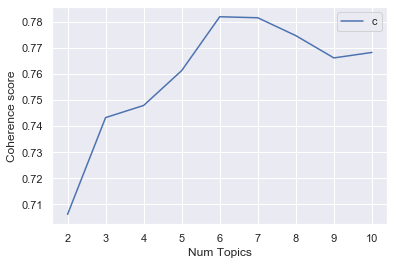

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7062
Num Topics = 3  has Coherence Value of 0.7432
Num Topics = 4  has Coherence Value of 0.7479
Num Topics = 5  has Coherence Value of 0.7612
Num Topics = 6  has Coherence Value of 0.7818
Num Topics = 7  has Coherence Value of 0.7815
Num Topics = 8  has Coherence Value of 0.7746
Num Topics = 9  has Coherence Value of 0.7661
Num Topics = 10  has Coherence Value of 0.7682


In [24]:
optimal_model = model_list[4] # Number of Topics = 6

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.131*"worth" + 0.090*"view" + 0.078*"close" + 0.041*"beach" + 0.041*"gem" '
  '+ 0.025*"plain" + 0.020*"limited" + 0.020*"boy" + 0.020*"stay" + '
  '0.020*"high"'),
 (1,
  '0.159*"expensive" + 0.096*"flamingo" + 0.050*"center" + 0.042*"hard" + '
  '0.038*"late" + 0.038*"black" + 0.025*"crowd" + 0.025*"early" + 0.025*"lion" '
  '+ 0.021*"private"'),
 (2,
  '0.194*"game" + 0.115*"experience" + 0.083*"city" + 0.036*"unbelievable" + '
  '0.032*"average" + 0.032*"tour" + 0.020*"trip" + 0.016*"water" + 0.016*"dry" '
  '+ 0.016*"hide"'),
 (3,
  '0.141*"elephant" + 0.121*"time" + 0.048*"baby" + 0.028*"big" + '
  '0.024*"morning" + 0.020*"variety" + 0.020*"kid" + 0.016*"feed" + '
  '0.016*"visit" + 0.016*"green"'),
 (4,
  '0.149*"small" + 0.056*"pink" + 0.048*"drive" + 0.044*"lot" + 0.044*"spend" '
  '+ 0.032*"rhino" + 0.028*"giraffe" + 0.028*"visit" + 0.024*"white" + '
  '0.024*"half"'),
 (5,
  '0.121*"animal" + 0.107*"long" + 0.062*"day" + 0.051*"bit" + '
  '0.048*"wildlife" + 0.040*

In [25]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.148005  0.093619       1        1  16.717600
3      0.125100  0.326714       2        1  16.693567
0      0.251388 -0.169915       3        1  16.671052
2     -0.265143 -0.237819       4        1  16.664279
4      0.217207 -0.124781       5        1  16.647606
1     -0.180547  0.112183       6        1  16.605896, topic_info=    Category       Freq          Term      Total  loglift  logprob
12   Default  58.000000          game  58.000000  30.0000  30.0000
81   Default  47.000000     expensive  47.000000  29.0000  29.0000
49   Default  45.000000         small  45.000000  28.0000  28.0000
18   Default  42.000000      elephant  42.000000  27.0000  27.0000
84   Default  39.000000         worth  39.000000  26.0000  26.0000
47   Default  36.000000        animal  36.000000  25.0000  25.0000
7    Default  36.000000          time  36.000000  24.0000  24.0000
94   Default  34.000000    experience  34.000000  23.0000  23.0000
3    Default  32.000000          long  32.000000  22.0000  22.0000
14   Default  27.000000          view  27.000000  21.0000  21.0000
36   Default  31.000000      flamingo  31.000000  20.0000  20.0000
32   Default  25.000000          city  25.000000  19.0000  19.0000
38   Default  23.000000         close  23.000000  18.0000  18.0000
130  Default  17.000000          pink  17.000000  17.0000  17.0000
86   Default  22.000000           day  22.000000  16.0000  16.0000
30   Default  15.000000           bit  15.000000  15.0000  15.0000
124  Default  15.000000        center  15.000000  14.0000  14.0000
112  Default  14.000000          baby  14.000000  13.0000  13.0000
138  Default  14.000000         drive  14.000000  12.0000  12.0000
24   Default  14.000000      wildlife  14.000000  11.0000  11.0000
205  Default  13.000000         spend  13.000000  10.0000  10.0000
48   Default  13.000000           lot  13.000000   9.0000   9.0000
39   Default  12.000000          hard  12.000000   8.0000   8.0000
279  Default  12.000000           gem  12.000000   7.0000   7.0000
324  Default  12.000000         beach  12.000000   6.0000   6.0000
162  Default  12.000000          walk  12.000000   5.0000   5.0000
1    Default  11.000000          late  11.000000   4.0000   4.0000
178  Default  11.000000         black  11.000000   3.0000   3.0000
75   Default  16.000000  unbelievable  16.000000   2.0000   2.0000
190  Default   9.000000       average   9.000000   1.0000   1.0000
..       ...        ...           ...        ...      ...      ...
151   Topic6   1.258991      chilling   1.258991   1.7954  -5.4765
167   Topic6   1.258991           mob   1.258991   1.7954  -5.4765
124   Topic6  15.107892        center  15.107892   1.7954  -2.9916
1     Topic6  11.330919          late  11.330919   1.7954  -3.2792
178   Topic6  11.330919         black  11.330919   1.7954  -3.2792
41    Topic6   7.553946         early   7.553946   1.7954  -3.6847
185   Topic6   7.553946         crowd   7.553946   1.7954  -3.6847
44    Topic6   7.553946          lion   7.553946   1.7954  -3.6847
192   Topic6   6.294955        orphan   6.294955   1.7954  -3.8670
394   Topic6   6.294955       private   6.294955   1.7954  -3.8670
191   Topic6   3.776973        boring   3.776973   1.7954  -4.3779
223   Topic6   3.776973           fee   3.776973   1.7954  -4.3779
193   Topic6   3.776973         reach   3.776973   1.7954  -4.3779
412   Topic6   3.776973         tough   3.776973   1.7954  -4.3779
289   Topic6   3.776973          spot   3.776973   1.7954  -4.3779
73    Topic6   3.776973     highlight   3.776973   1.7954  -4.3779
109   Topic6   3.776973        baboon   3.776973   1.7954  -4.3779
429   Topic6   2.517982        common   2.517982   1.7954  -4.7833
555   Topic6   1.258991        fairly   1.258991   1.7954  -5.4765
552   Topic6   1.258991       message   1.258991   1.7954  -5.4765
359   Topic6   1.258991         event   1

In [26]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1830,"expensive, flamingo, center, hard, late, black...",Go before it is too late
1,1,1.0,0.1808,"expensive, flamingo, center, hard, late, black...",A sea of pink.
2,2,0.0,0.1667,"worth, view, close, beach, gem, plain, limited...",disappointed
3,3,3.0,0.1761,"elephant, time, baby, big, morning, variety, k...",11 mile long white sand
4,4,3.0,0.1987,"elephant, time, baby, big, morning, variety, k...",Time your visit carefully
5,5,3.0,0.1770,"elephant, time, baby, big, morning, variety, k...",Fulfilled a long held dream
6,6,0.0,0.1728,"worth, view, close, beach, gem, plain, limited...",Big Game View in a just a few hours !
7,7,0.0,0.1667,"worth, view, close, beach, gem, plain, limited...",Very dry
8,8,0.0,0.1667,"worth, view, close, beach, gem, plain, limited...",Average
9,9,0.0,0.1830,"worth, view, close, beach, gem, plain, limited...",Game Watchers Safari


In [27]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    402
1.0    123
2.0    108
5.0    103
3.0    103
4.0     96
Name: Dominant_Topic, dtype: int64

In [28]:
df_dominant_topic.to_csv('kenya_442.csv', index = False)

In [35]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Lack of Content - 402
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Expensive Fees - 123
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Topicless/Unidentifiable - 108
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Topicless/Unidentifiable - 103
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Topicless/Unidentifiable - 96
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Lack of Content - 103

In [36]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Lack of Content - 361
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Lack of Content - 78
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Describing Smallness - 71
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Expensive Fees - 71
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # General Criticism - 73
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Not Worth Time - 57
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Expressing Boredom - 61
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # General Criticism - 48
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # Expressing Boredom - 49
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 9]['Text'].values # Expensive Fees - 66

In [37]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2061,"worth, view, close, beach, gem, plain, limited...",French kissing a long necked girl in a place c...
1,1.0,0.2099,"expensive, flamingo, center, hard, late, black...",Not many flamingos but get there early for lio...
2,2.0,0.2096,"game, experience, city, unbelievable, average,...",A game park adjacent to a city - unbelievable!
3,3.0,0.2202,"elephant, time, baby, big, morning, variety, k...",Sanctuary for baby Elephants and Rhinos whose ...
4,4.0,0.2099,"small, pink, drive, lot, spend, rhino, giraffe...",Lots of wild animals to see in such a small place
5,5.0,0.2263,"animal, long, day, bit, wildlife, walk, money,...",Holy crap thats alot of animals


In [38]:
sent_topics_sorteddf_mallet['Text'].values

array(['French kissing a long necked girl in a place called Karen, Nairobi',
       'Not many flamingos but get there early for lions and leopards!',
       'A game park adjacent to a city - unbelievable!',
       'Sanctuary for baby Elephants and Rhinos whose parents have been killed by poachers',
       'Lots of wild animals to see in such a small place',
       'Holy crap thats alot of animals'], dtype=object)

In [39]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics